In [1]:
import sys
import numpy as np
import librosa

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import os

# import chainer
# from chainer import cuda, Variable, Chain, serializers
# import chainer.functions as F
# import chainer.links as L

# sys.path.append('../networks/')
from network import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
logmel_Res = []
freqs = range(7995, 0, -10)
wav_len = int(16000 * 1.5)
fs = 16000 

for freq in freqs:
    response = np.zeros([40])
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
#     print x, len(x)
    melspec = librosa.feature.melspectrogram(x, 16000, n_fft=800, hop_length=160, n_mels=40) # (40, 151)
#     print melspec, melspec.shape
    logmel = librosa.logamplitude(melspec) # (40, 151)
#     print 'logmel: ', logmel, logmel.shape
    res = np.mean(logmel[:, 10: 140], axis=1) # (40,)
#     print 'res: ', res, res.shape
    logmel_Res.append(res)
#     break
logmel_Res = np.array(logmel_Res) # (800, 40)
print logmel_Res
print logmel_Res.shape
mel_freq = 7995 - 10 * np.argmax(logmel_Res, axis=0)
print mel_freq

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8) # (801, 41) (801, 41)
# print x.shape, y.shape
# print x
# print y
# plt.pcolor(x, y, np.flipud(logmel_Res)) # np.flipud 矩阵上下翻转
plt.pcolor(x, y, logmel_Res) # np.flipud 矩阵上下翻转
plt.title('log-mel feature', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)

In [ ]:
# Create sin waves

freqs = range(7995, 0, -10)
wav_len = int(44100 * 1.5)
fs = 44100
X = []

for freq in freqs:
    x = np.array([np.sin(2.0 * np.pi * freq * i / fs) for i in range(wav_len)])
    X.append(x[np.newaxis, :])
X = np.array(X).astype(np.float32) # (800, 1, fs*1.5)
# print X
print X.shape

In [28]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

model = torch.load('../model/EnvNetMS_fold0_v1_epoch150.pkl')
model.cuda()

# print model
# Calculate pool2 of EnvNet
batchsize = 32
Res = []
N = 800

Xt = torch.from_numpy(X)
Xt = Xt.cuda()
Xt = Variable(Xt)
for i in xrange(0, N, batchsize):
    print i
    x = Xt[i: i+batchsize]
    x = model.conv1(x)   # (batchSize, 80L, 24001L)
    x = F.relu(model.bn1(x))
    
    x = model.conv2(x)   # (batchSize, 40L, 24000L)
    x = F.relu(model.bn2(x))
    x = model.pool2(x)  # (batchSize, 40L, 150L)    
#     print pool2
#     res = np.average(pool2, axis=2)
    res = torch.mean(x, dim=2)
    Res.extend(res.data.cpu().numpy())

# print Res
Res = np.asarray(Res)
print Res.shape


IOError: [Errno 2] No such file or directory: '../model/EnvNetMS__fold0_v1_epoch150.pkl'

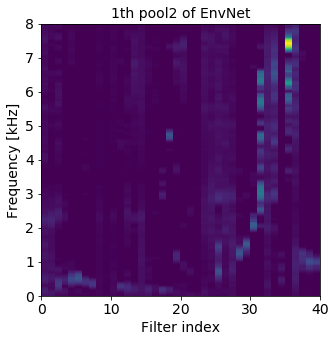

In [26]:
fig = plt.figure(figsize=(5, 5))


x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(Res))
plt.title('1th pool2 of EnvNet', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)


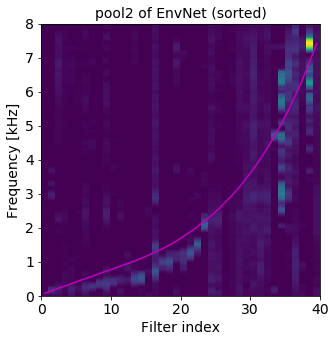

In [27]:
center_freq = 7995 - 10 * np.argmax(Res, axis=0)
# rm_index = [5, 6, 7, 8, 18] # filters which respond to all frequency area are removed
# center_freq[rm_index] = 8000
sort_index = np.argsort(center_freq)[:40]
sorted_Res = Res[:, sort_index]

fig = plt.figure(figsize=(5, 5))

x, y = np.meshgrid(np.arange(41), np.arange(801) / 801. * 8)
plt.pcolor(x, y, np.flipud(sorted_Res))
plt.plot(np.arange(40) * (40) / 40. + 0.5 , mel_freq / 1000., 'm')
plt.title('pool2 of EnvNet (sorted)', fontsize=14)
plt.xlabel('Filter index', fontsize=14)
plt.ylabel('Frequency [kHz]', fontsize=14)
plt.tick_params(labelsize=14)


In [34]:
np.savetxt('../figures/txt/response.txt', Res)
np.savetxt('../figures/txt/sorted_response.txt', sorted_Res)
np.savetxt('../figures/txt/logmel_response.txt', logmel_Res)
np.savetxt('../figures/txt/mel_freq.txt', mel_freq)